In [31]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

In [32]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('telco_train.csv')
df.head()
df_original = df.copy()

Saving telco_train.csv to telco_train (3).csv


**Data Cleaning & Preprocessing**

In [33]:
# Step 1: Basic preprocessing
df.drop(['customerID'], axis=1, inplace=True)  # Not useful for prediction

# Convert TotalCharges to numeric (it has some missing values as spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 🆕 Handle missing values (across all columns)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Handle missing values
df.dropna(inplace=True)

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


**Train-Test Split**

In [34]:
from sklearn.model_selection import train_test_split

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


**Train a Model (Logistic Regression & Random Forest)**

In [35]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# Logistic Regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict_proba(X_val_scaled)[:, 1]
lr_auc = roc_auc_score(y_val, lr_preds)

# Random Forest (no scaling needed for tree-based models)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_preds)

# XGBoost (no need to scale data, but you *can* if you want)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_preds)

# Output AUC Scores
print(f"Logistic Regression AUC: {lr_auc:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"XGBoost AUC: {xgb_auc:.4f}")

Logistic Regression AUC: 0.8613
Random Forest AUC: 0.8364
XGBoost AUC: 0.8361


In [36]:
print("Logistic Regression Report:")
print(classification_report(y_val, lr.predict(X_val_scaled)))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



**Saving Prediction**

In [37]:
# Using my best model (say, logistic regression) for prediction
predictions = lr.predict_proba(X_val)[:, 1]

# Save to CSV format
output_df = pd.DataFrame({
    'CustomerID': df_original.loc[X_val.index, 'customerID'].values,
    'Churn_Probability': predictions
})
output_df.to_csv("predictions.csv", index=False)

from google.colab import files
files.download("predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model Interpretability (Feature Importance)**

<Axes: title={'center': 'Logistic Regression Coefficients'}>

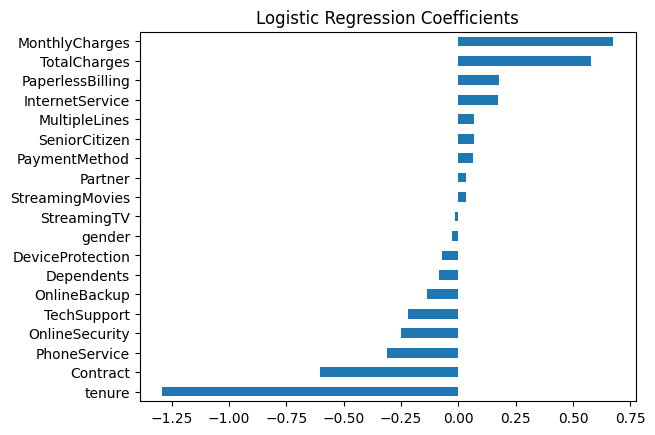

In [38]:
importance = pd.Series(lr.coef_[0], index=X.columns)
importance.sort_values().plot(kind='barh', title='Logistic Regression Coefficients')


In [39]:
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(lr, "model.pkl")
files.download("label_encoders.pkl")
files.download("scaler.pkl")
files.download("model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>